In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

import generate_controldf as gm
from preproc_funcs import *
from generate_plots import *
from helpers import *
from preproc_funcs import *
from scipy import stats
import plotly.graph_objects as go
from statsmodels.stats.anova import AnovaRM
import pingouin as pg

pd.set_option("display.max.columns", None)
pd.set_option("display.precision", 4)

msize = 10
axes_fontsize = 14
title_fontsize = 18
%load_ext autoreload
%autoreload 2

Creating a new dataframe.
We have 10 subjects so far: [1, 5, 7, 10, 12, 14, 15, 23, 25, 26]

Running subj = 1, day = 06
Running subj = 5, day = 06
Running subj = 7, day = 06
Running subj = 10, day = 06
Running subj = 12, day = 06
Running subj = 14, day = 06
Running subj = 15, day = 06
Running subj = 23, day = 06
Running subj = 25, day = 06
Running subj = 26, day = 06


In [2]:
# Loading the data as a dataframe
df_calib_orig = gm.master_df

# Add additonal error metrics
df_calib_orig = add_metrics(df_calib_orig)

# Preprocess and filter both datasets
df_calib = filter_data_controlTask(df_calib_orig)

sub_list = np.unique(df_calib['subjID'].values)

Trials removed = 212 = 5.3% 
Timing issues = 0 = 0.0% 
No saccades detected issues = 85 = 2.12% 
Reaction time issues = 5 = 0.12% 
Large errors = 122 = 3.05% 



In [ ]:
# Choose what you wanna see
print('Dataframe description')
df_calib.info()
df_calib.describe(include=object)

In [3]:
subs_to_remove = []
# subs_to_remove = [11, 16, 18]
df_calib_filt = elim_subs_blocks_control(df_calib, subs_to_remove)
sub_list_filt = [ss for ss in sub_list if ss not in subs_to_remove]

Removed subjects: []
Removed blocks df1:
   subjID  day  rnum
0      12    6     9


/var/folders/cf/d9j3_ppd5wb4bn9y_fgj3nb800010l/T/ipykernel_9636/3554303301.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(['hemiIn', 'hemiOut'])
/var/folders/cf/d9j3_ppd5wb4bn9y_fgj3nb800010l/T/ipykernel_9636/3554303301.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(['hemiIn', 'hemiOut'])
/var/folders/cf/d9j3_ppd5wb4bn9y_fgj3nb800010l/T/ipykernel_9636/3554303301.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(['hemiIn', 'hemiOut'])
/var/folders/cf/d9j3_ppd5wb4bn9y_fgj3nb800010l/T/ipykernel_9636/3554303301.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xti

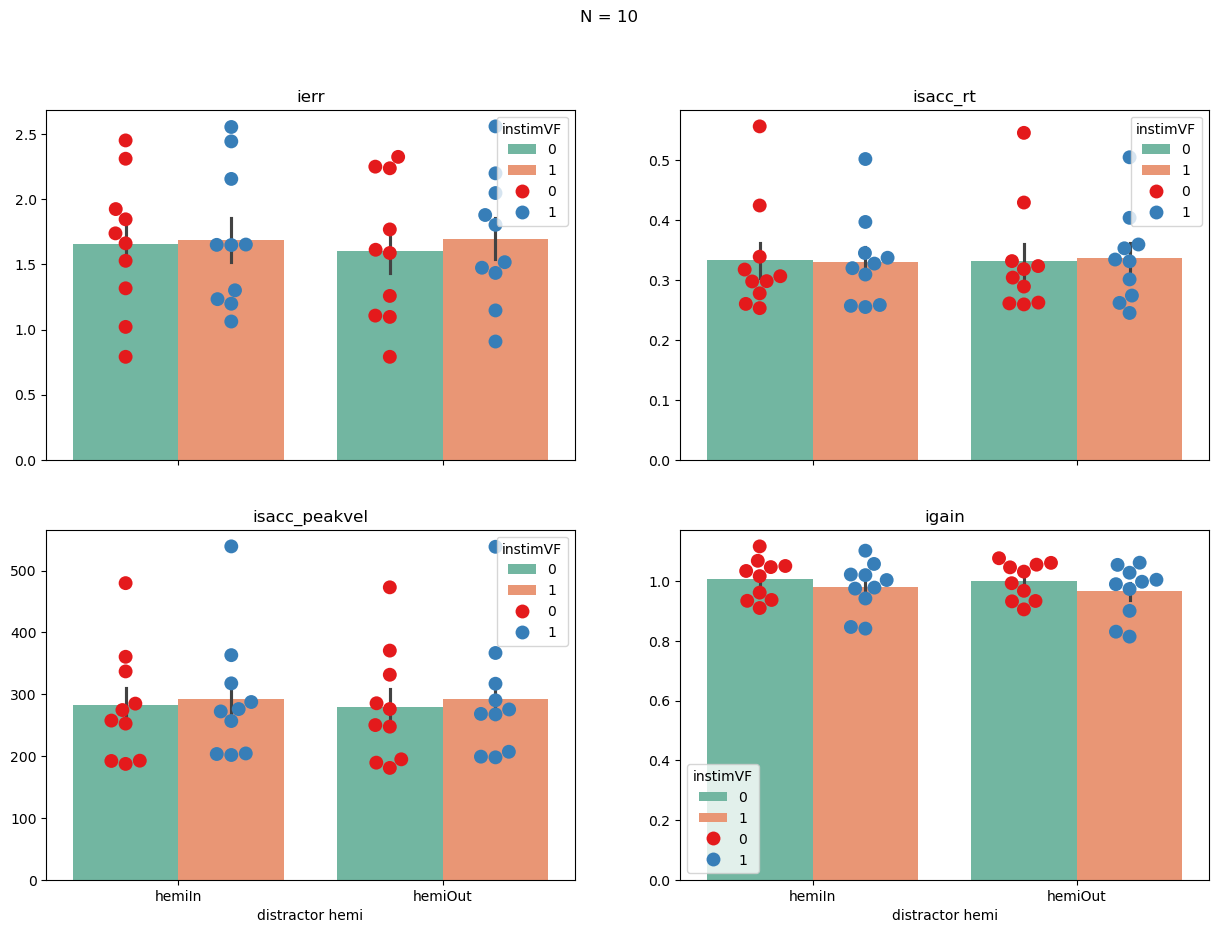

In [4]:
metricsToPlot = ['ierr', 'isacc_rt', 'isacc_peakvel', 'igain']

f, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=True)
axs = axs.ravel()
for i, metric in enumerate(metricsToPlot):
    dfThis = df_calib_filt.groupby(['subjID', 'distractorHemi', 'instimVF'])[metric].mean().reset_index()
    # sns.boxplot(x='distractorHemi', y=metric, hue='instimVF', data=dfThis, ax=axs[i], palette='Set2')
    sns.barplot(x='distractorHemi', y=metric, hue='instimVF', data=dfThis, ax=axs[i], palette='Set2', errorbar='se')
    sns.swarmplot(x='distractorHemi', y=metric, hue='instimVF', data=dfThis, ax=axs[i], dodge=True,
                    palette='Set1', size=msize)

    axs[i].set_title(metric)
    axs[i].set_xlabel('distractor hemi')
    axs[i].set_ylabel('')
    axs[i].set_xticklabels(['hemiIn', 'hemiOut'])
# plt.tight_layout()
plt.suptitle(f'N = {len(sub_list_filt)}')
plt.show()

In [6]:
sub_list_filt

[1, 5, 10, 12, 14, 15, 23, 25, 26]

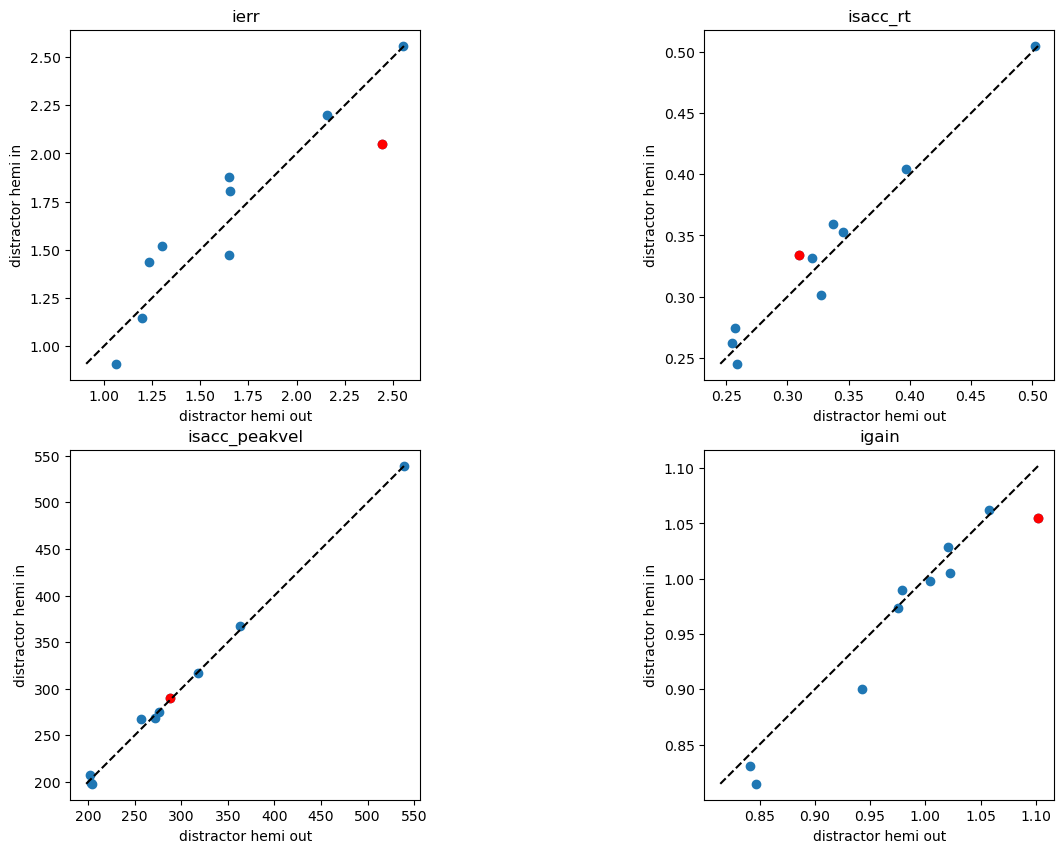

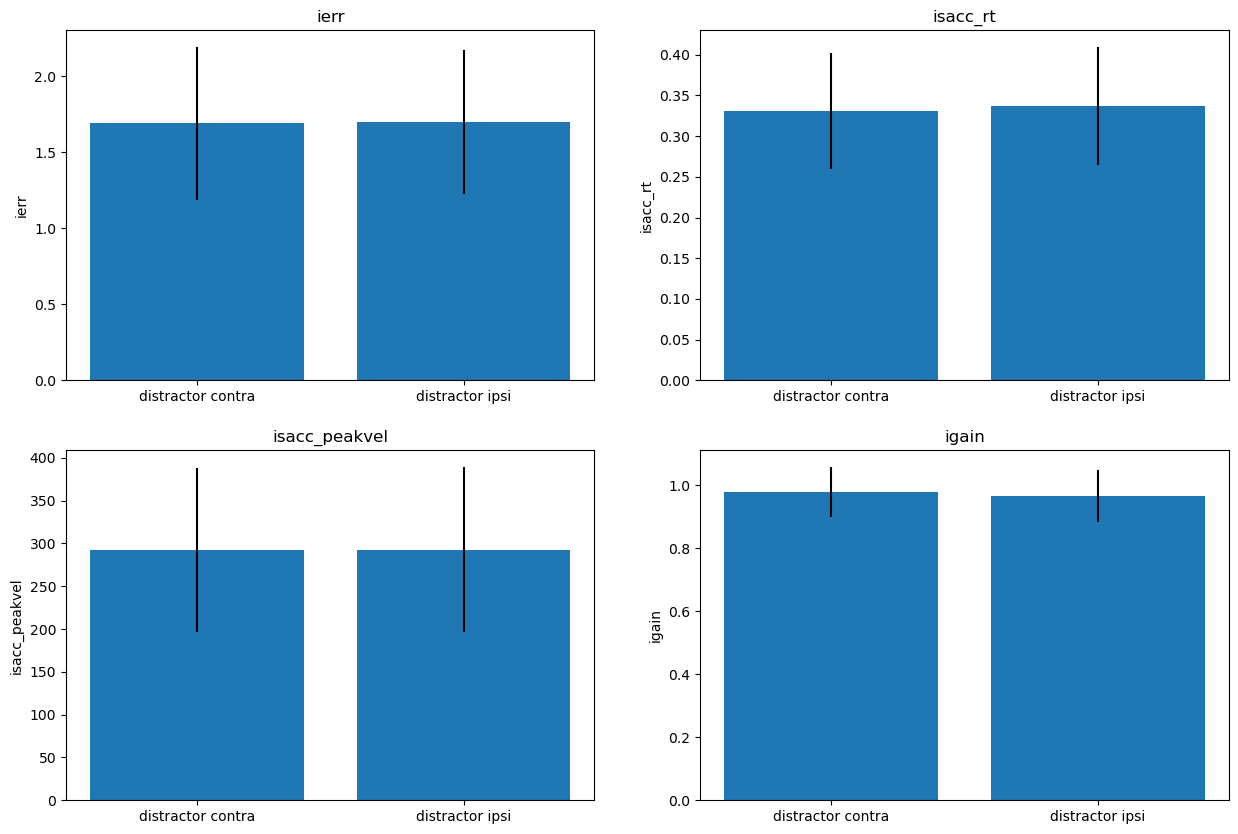

In [5]:
# Create a plot for each metric for trials where target was inside hemifield stimulated during main experiment (instimVF = 1)
# for distractor in and out of the hemifield
# If phosphenes did cause larger errors, we would expect the distractor in to have larger errors than distractor out
metricsToPlot = ['ierr', 'isacc_rt', 'isacc_peakvel', 'igain']

valHolder = np.empty((len(sub_list_filt), len(metricsToPlot), 2)) # 0 = distractorOut, 1 = distractorIn

for xx in range(len(sub_list_filt)):
    dfThis = df_calib_filt[(df_calib_filt['subjID'] == sub_list_filt[xx]) & (df_calib_filt['instimVF'] == 1)]

    for yy in range(len(metricsToPlot)):
        valHolder[xx, yy, 0] = dfThis[dfThis['distractorHemi'] == 0][metricsToPlot[yy]].mean()
        valHolder[xx, yy, 1] = dfThis[dfThis['distractorHemi'] == 1][metricsToPlot[yy]].mean()

f, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.ravel()
for i, metric in enumerate(metricsToPlot):
    axs[i].set_title(metric)
    axs[i].plot(valHolder[:, i, 0], valHolder[:, i, 1], 'o')
    axs[i].plot(valHolder[2, i, 0], valHolder[2, i, 1], 'ro')
    axs[i].set_xlabel('distractor hemi out')
    axs[i].set_ylabel('distractor hemi in')

    xyMin = np.min([np.min(valHolder[:, i, 0]), np.min(valHolder[:, i, 1])])
    xyMax = np.max([np.max(valHolder[:, i, 0]), np.max(valHolder[:, i, 1])])
    axs[i].plot([xyMin, xyMax], [xyMin, xyMax], 'k--')
    axs[i].set_aspect('equal')

plt.show()

f, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.ravel()
for i, metric in enumerate(metricsToPlot):
    axs[i].set_title(metric)
    axs[i].bar([0, 1], [valHolder[:, i, 0].mean(), valHolder[:, i, 1].mean()], yerr=[valHolder[:, i, 0].std(), valHolder[:, i, 1].std()])
    axs[i].set_xticks([0, 1])
    axs[i].set_xticklabels(['distractor contra', 'distractor ipsi'])
    axs[i].set_ylabel(metric)
plt.show()

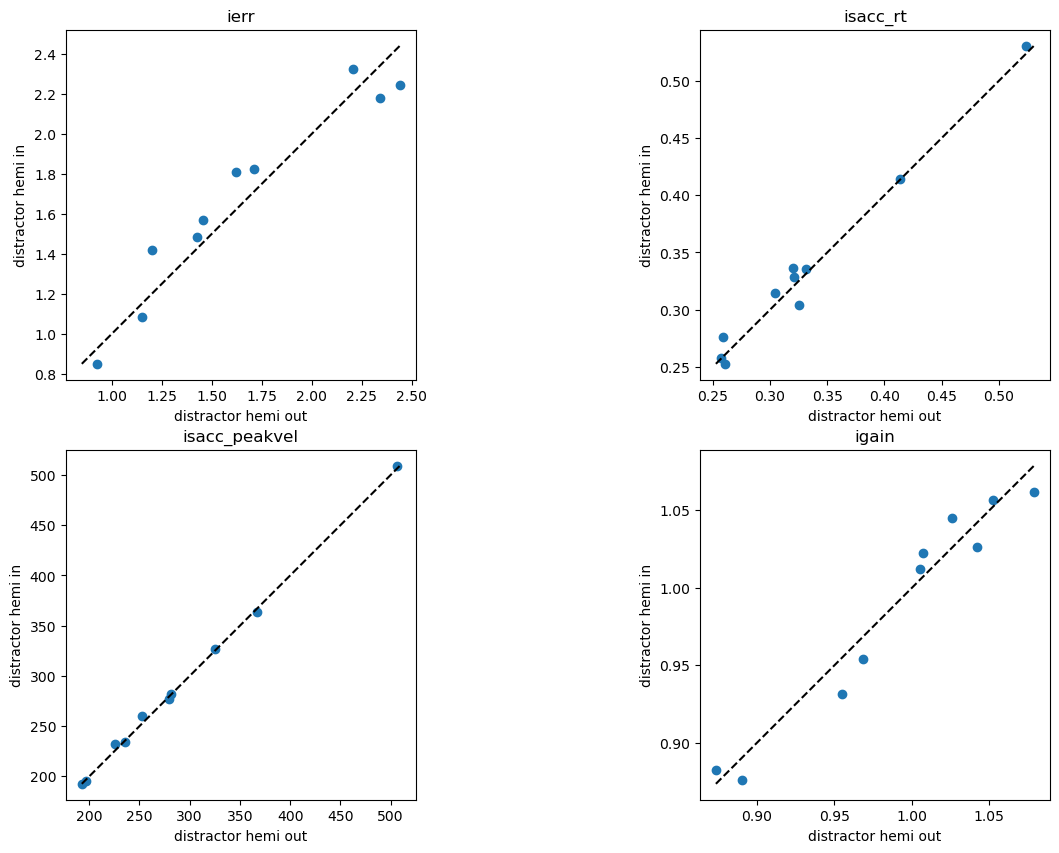

ierr t = -0.6704938455559194, p = 0.5193760331749964
isacc_rt t = -0.9246958994599603, p = 0.3792500065276382
isacc_peakvel t = -1.0841707490743726, p = 0.306476623732991
igain t = 0.6066459166906583, p = 0.5590758701620211


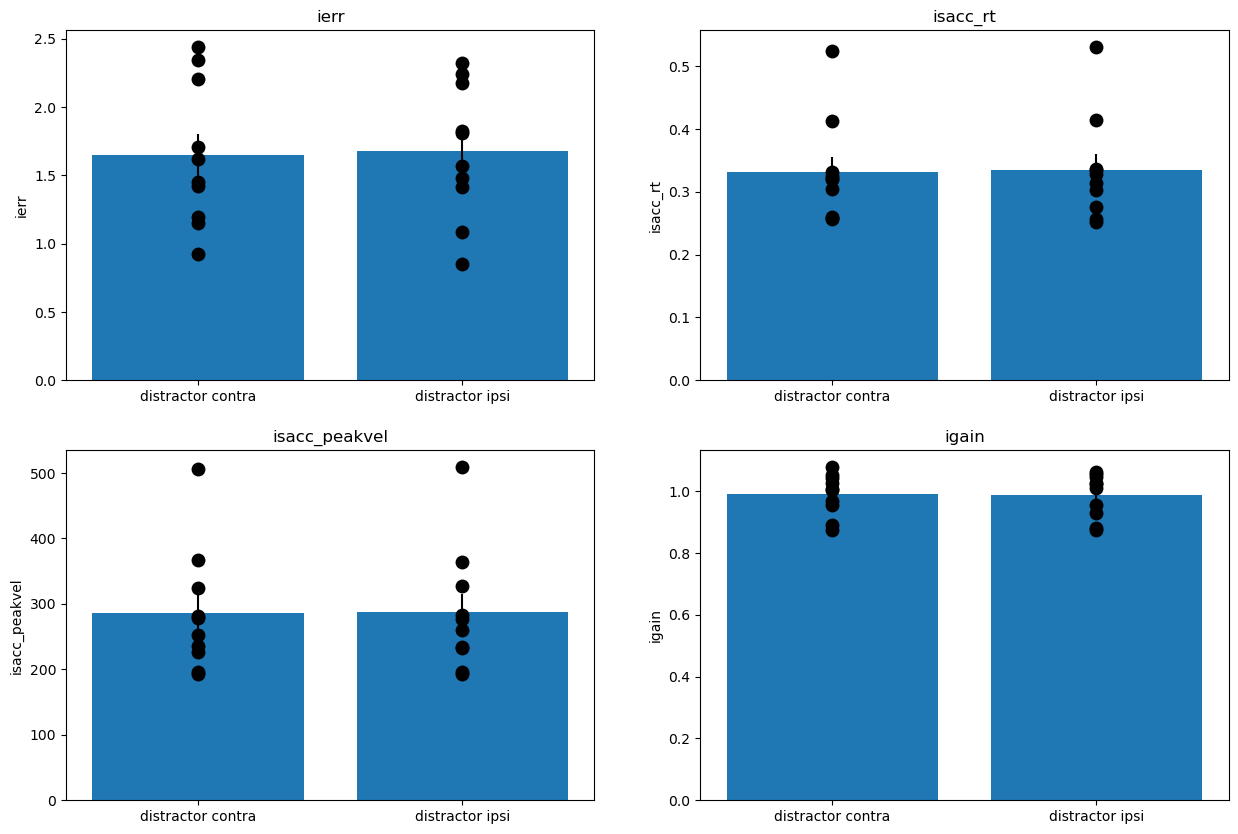

In [19]:
# Repeat the same now combine conditions to check if distractor present inside or outisde the hemifield matters
metricsToPlot = ['ierr', 'isacc_rt', 'isacc_peakvel', 'igain']

# Initialize the holder for data
valHolder = np.empty((len(sub_list_filt), len(metricsToPlot), 2))  # 0 = distractorOut, 1 = distractorIn

for xx in range(len(sub_list_filt)):
    # Filter the DataFrame for the current subject
    dfThis = df_calib_filt[df_calib_filt['subjID'] == sub_list_filt[xx]]
    
    for yy in range(len(metricsToPlot)):
        df_instimVF1 = dfThis[dfThis['instimVF'] == 1]
        valHolder[xx, yy, 0] = df_instimVF1[df_instimVF1['distractorHemi'] == 0][metricsToPlot[yy]].mean()
        valHolder[xx, yy, 1] = df_instimVF1[df_instimVF1['distractorHemi'] == 1][metricsToPlot[yy]].mean()
        df_instimVF0 = dfThis[dfThis['instimVF'] == 0]
        valHolder[xx, yy, 0] += df_instimVF0[df_instimVF0['distractorHemi'] == 1][metricsToPlot[yy]].mean()
        valHolder[xx, yy, 1] += df_instimVF0[df_instimVF0['distractorHemi'] == 0][metricsToPlot[yy]].mean()
        valHolder[xx, yy, 0] /= 2
        valHolder[xx, yy, 1] /= 2

# Plotting
f, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.ravel()
for i, metric in enumerate(metricsToPlot):
    axs[i].set_title(metric)
    axs[i].plot(valHolder[:, i, 0], valHolder[:, i, 1], 'o')
    # axs[i].plot(valHolder[2, i, 0], valHolder[2, i, 1], 'ro')
    axs[i].set_xlabel('distractor hemi out')
    axs[i].set_ylabel('distractor hemi in')

    xyMin = np.min([np.min(valHolder[:, i, 0]), np.min(valHolder[:, i, 1])])
    xyMax = np.max([np.max(valHolder[:, i, 0]), np.max(valHolder[:, i, 1])])
    axs[i].plot([xyMin, xyMax], [xyMin, xyMax], 'k--')
    axs[i].set_aspect('equal')

plt.show()

f, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.ravel()
for i, metric in enumerate(metricsToPlot):
    axs[i].set_title(metric)
    axs[i].bar([0, 1], [valHolder[:, i, 0].mean(), valHolder[:, i, 1].mean()],
                yerr=[valHolder[:, i, 0].std()/np.sqrt(len(sub_list_filt)), valHolder[:, i, 1].std()/np.sqrt(len(sub_list_filt))])
    t, p = stats.ttest_rel(valHolder[:, i, 0], valHolder[:, i, 1])
    sns.stripplot(x=0, y=valHolder[:, i, 0], ax=axs[i], color='black', size=msize, jitter=False)
    sns.stripplot(x=1, y=valHolder[:, i, 1], ax=axs[i], color='black', size=msize, jitter=False)
    print(f'{metric} t = {t}, p = {p}')
    # if metric == 'ierr':
    #     axs[i].set_ylim([0.75, 2])
    axs[i].set_xticks([0, 1])
    axs[i].set_xticklabels(['distractor contra', 'distractor ipsi'])
    axs[i].set_ylabel(metric)
plt.savefig('/d/DATA/hyper/manuscripts/Dake_Curtis_2024/rev1/controlFig.eps', format = 'eps', dpi = 1200)

plt.show()


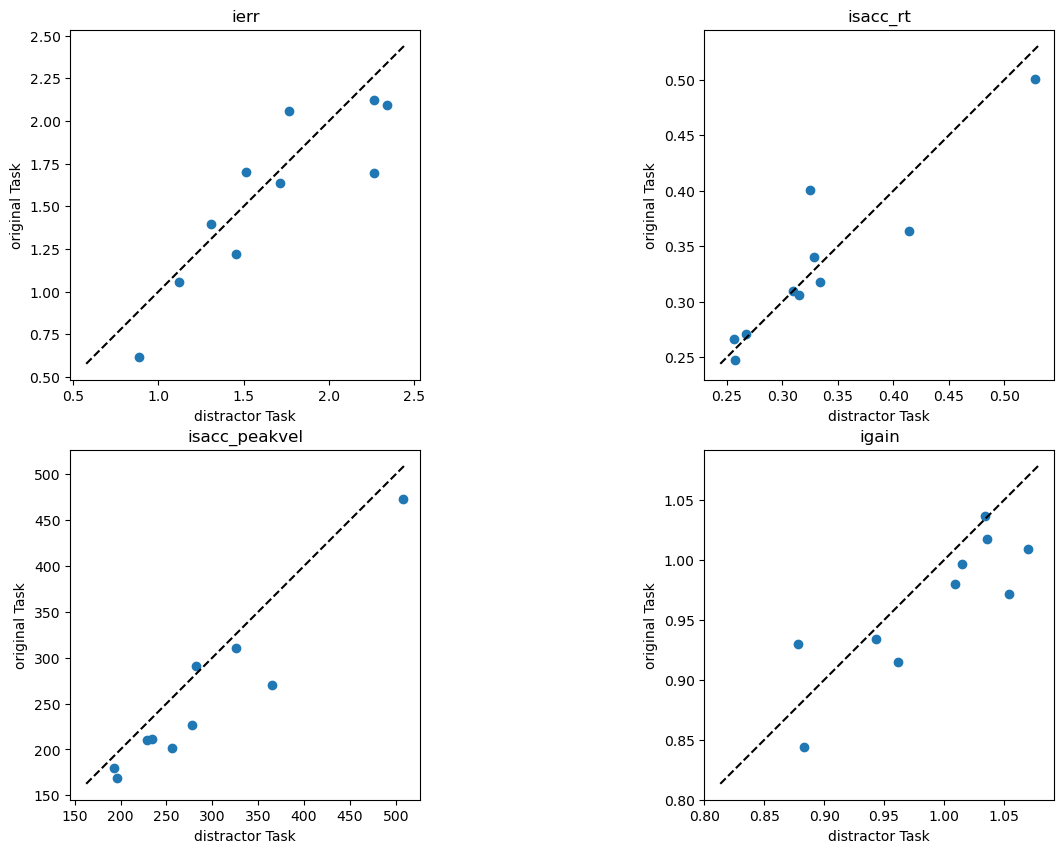

ierr t = 1.7274665871670594, p = 0.10030467315037088
isacc_rt t = 0.13246905041293977, p = 0.896006138113574
isacc_peakvel t = 4.602314034072325, p = 0.00019444246003699986
igain t = 2.3500026411078023, p = 0.029731510854718406


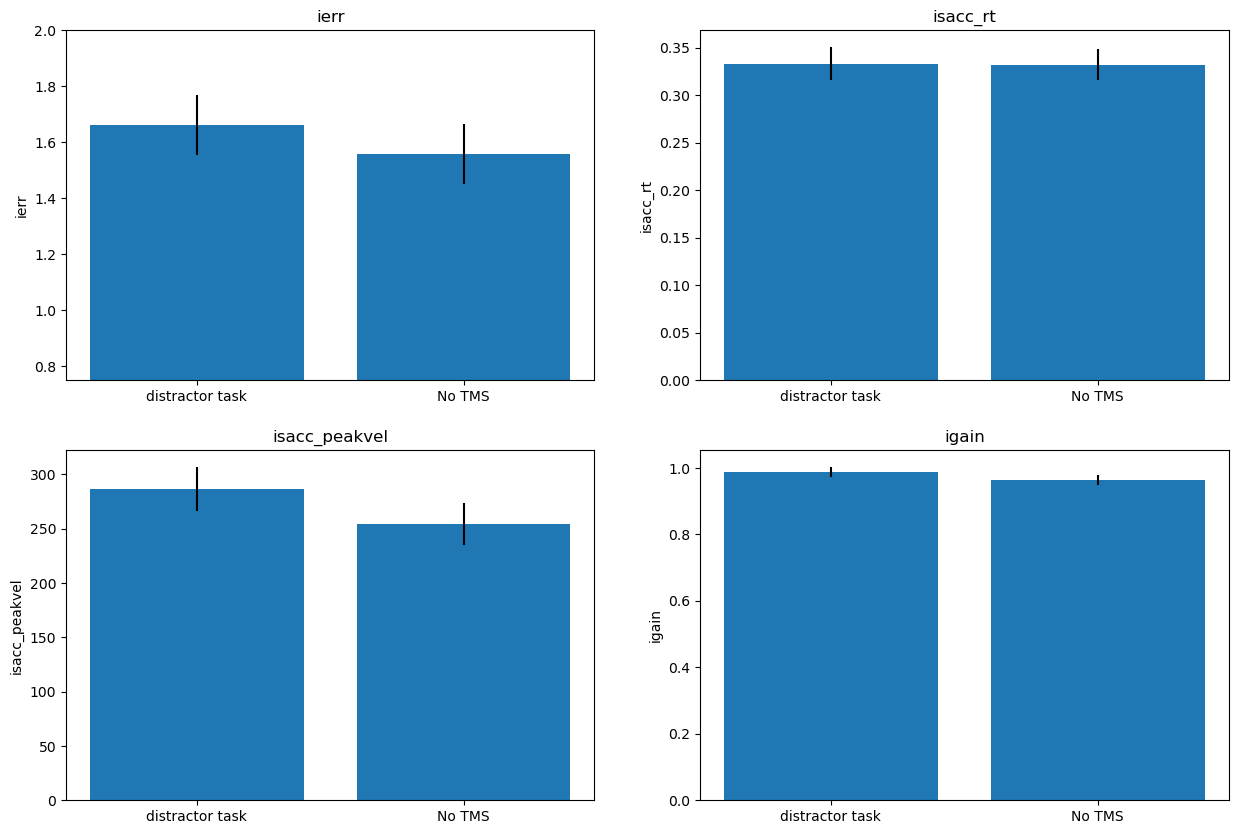

In [13]:
# Repeat the same now combine conditions to check if distractor present inside or outisde the hemifield matters
metricsToPlot = ['ierr', 'isacc_rt', 'isacc_peakvel', 'igain']
oldDF =  pd.read_csv('/d/DATD/datd/MD_TMS_EEG/analysis/meta_analysis/calib_all5_filtered.csv')

# Initialize the holder for data
valHolder = np.empty((len(sub_list_filt), len(metricsToPlot), 2))  # 0 = distractorOut, 1 = distractorIn
olHoler = np.empty((len(sub_list_filt), len(metricsToPlot), 2))  
for xx in range(len(sub_list_filt)):
    # Filter the DataFrame for the current subject
    dfThis = df_calib_filt[df_calib_filt['subjID'] == sub_list_filt[xx]]
    dfOldThis = oldDF[(oldDF['subjID'] == sub_list_filt[xx]) & (oldDF['ispro'] == 1) & (oldDF['istms']== 0)]
    
    for yy in range(len(metricsToPlot)):
        df_instimVF1 = dfThis[dfThis['instimVF'] == 1]
        valHolder[xx, yy, 0] = df_instimVF1[df_instimVF1['distractorHemi'] == 0][metricsToPlot[yy]].mean()
        valHolder[xx, yy, 1] = df_instimVF1[df_instimVF1['distractorHemi'] == 1][metricsToPlot[yy]].mean()
        df_instimVF0 = dfThis[dfThis['instimVF'] == 0]
        valHolder[xx, yy, 0] += df_instimVF0[df_instimVF0['distractorHemi'] == 1][metricsToPlot[yy]].mean()
        valHolder[xx, yy, 1] += df_instimVF0[df_instimVF0['distractorHemi'] == 0][metricsToPlot[yy]].mean()
        valHolder[xx, yy, 0] /= 2
        valHolder[xx, yy, 1] /= 2

        olddf_instimVF1 = dfOldThis[dfOldThis['instimVF'] == 1]
        olHoler[xx, yy, 0] = olddf_instimVF1[metricsToPlot[yy]].mean()
        olddf_instimVF0 = dfOldThis[dfOldThis['instimVF'] == 0]
        olHoler[xx, yy, 1] = olddf_instimVF0[metricsToPlot[yy]].mean()


# Plotting
f, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.ravel()
for i, metric in enumerate(metricsToPlot):
    axs[i].set_title(metric)
    axs[i].plot(np.mean(valHolder[:, i, :], axis = 1), np.mean(olHoler[:, i, :], axis = 1), 'o')
    # axs[i].plot(valHolder[2, i, 0], olHoler[2, i, 0], 'ro')
    # axs[i].plot(valHolder[0, i, 1], olHoler[0, i, 1], 'ko')
    axs[i].set_xlabel('distractor Task')
    axs[i].set_ylabel('original Task')
    xyMin = np.min([np.min(valHolder[:, i, 0]), np.min(valHolder[:, i, 1]), np.min(olHoler[:, i, 0]), np.min(olHoler[:, i, 1])])
    xyMax = np.max([np.max(valHolder[:, i, 0]), np.max(valHolder[:, i, 1]), np.max(olHoler[:, i, 0]), np.max(olHoler[:, i, 1])])
    axs[i].plot([xyMin, xyMax], [xyMin, xyMax], 'k--')
    axs[i].set_aspect('equal')
plt.show()

f, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.ravel()
for i, metric in enumerate(metricsToPlot):
    axs[i].set_title(metric)
    a1 = np.concatenate((valHolder[:, i, 0], valHolder[:, i, 1]))
    a2 = np.concatenate((olHoler[:, i, 0], olHoler[:, i, 1]))
    axs[i].bar([0, 1], [np.mean(a1), np.mean(a2)], yerr=[np.std(a1)/np.sqrt(len(a1)), np.std(a2)/np.sqrt(len(a2))])
    if metric == 'ierr':
        axs[i].set_ylim([0.75, 2])
    t, p = stats.ttest_rel(a1, a2)
    print(f'{metric} t = {t}, p = {p}')
    # axs[i].bar([0, 1], [np.mean(valHolder[:, i, 0]), np.mean(valHolder[:, i, 1]), np.mean(olHoler[:, i, 0]), np.mean(olHoler[:, i, 1])], 
    #            yerr=[np.std(valHolder[:, i, 0]), np.std(valHolder[:, i, 1]), np.std(olHoler[:, i, 0]), np.std(olHoler[:, i, 1])])
    axs[i].set_xticks([0, 1])
    axs[i].set_xticklabels(['distractor task', 'No TMS'])
    axs[i].set_ylabel(metric)

